In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from utils import get_data, ode_func, solve_ode
import torch
from PINN import PINN
from sklearn.preprocessing import MinMaxScaler

PATH = './data/'

In [21]:
model = PINN(1, 2)
model.load_state_dict(torch.load('./models/pinn_sparse.pth'))
mu_max = model.mu_max.item()
Km = model.Km.item()
Y_XS = model.Y_XS.item()

print(f"mu_max = {mu_max:.4f}")
print(f"Km = {Km:.4f}")
print(f"Y_XS = {Y_XS:.4f}")

mu_max = 0.8047
Km = 1.2796
Y_XS = 0.4797


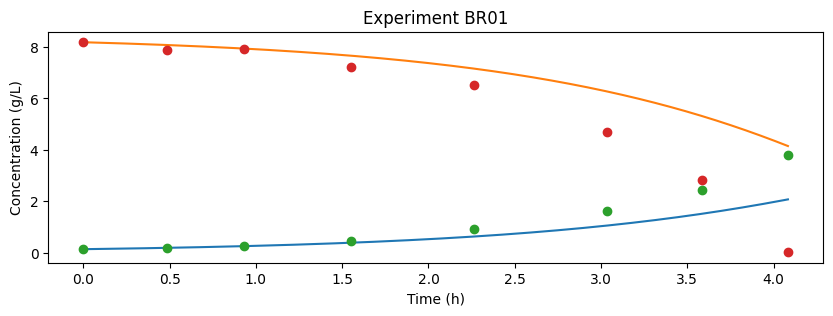

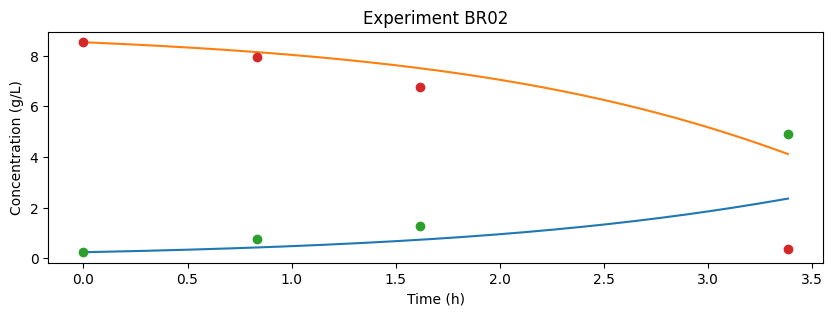

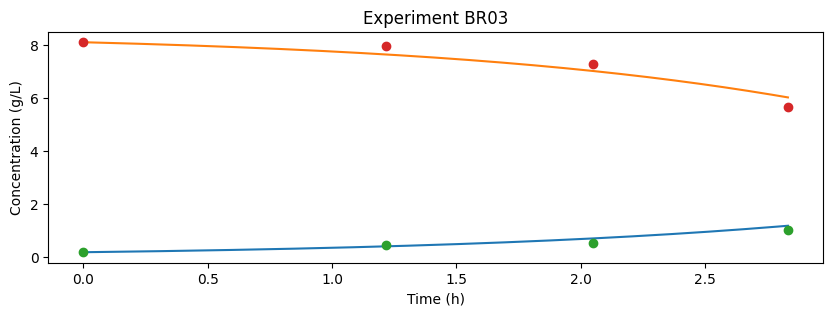

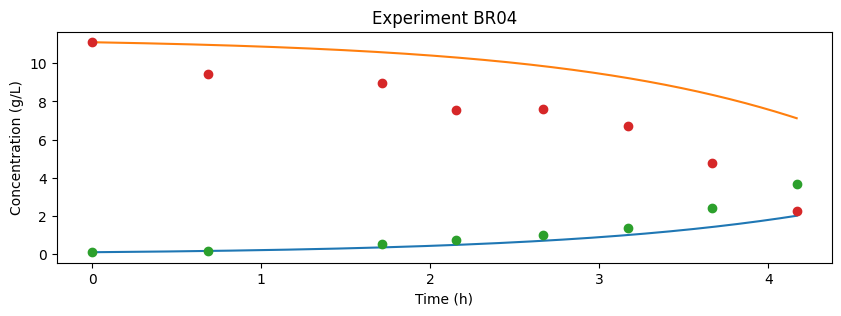

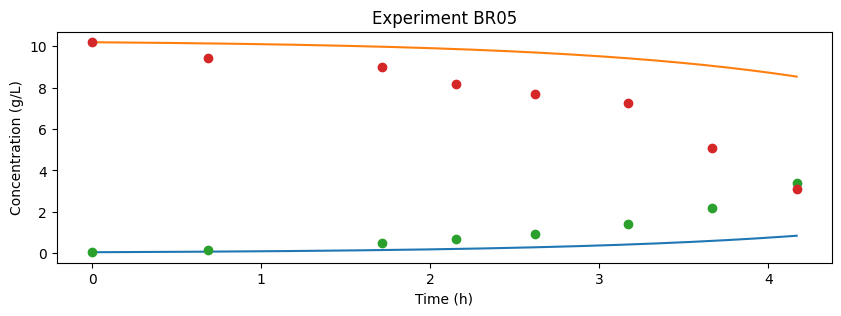

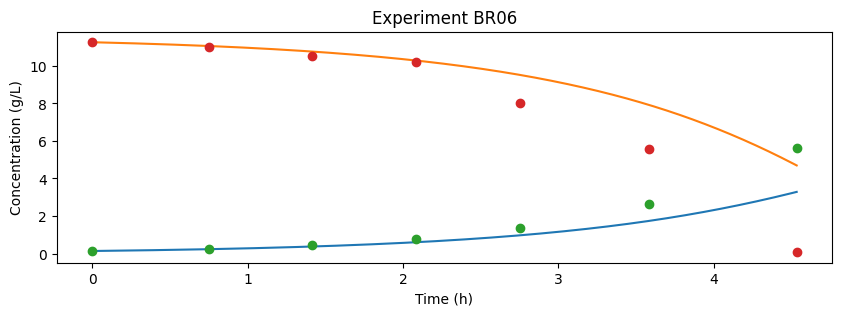

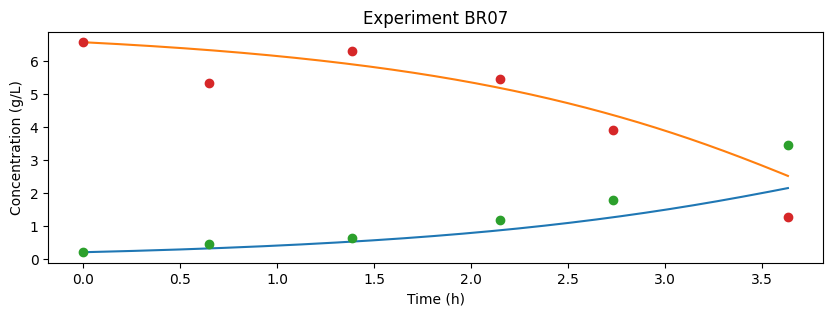

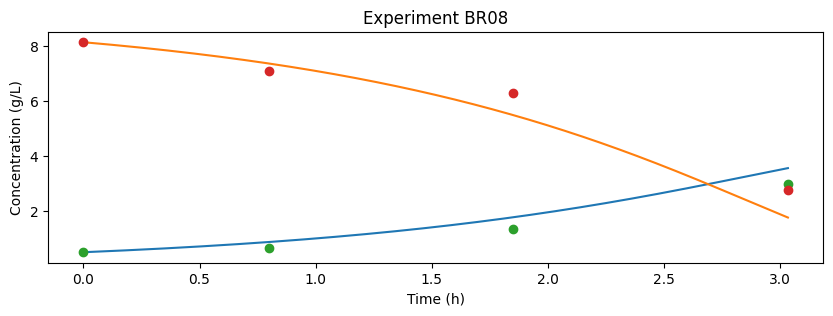

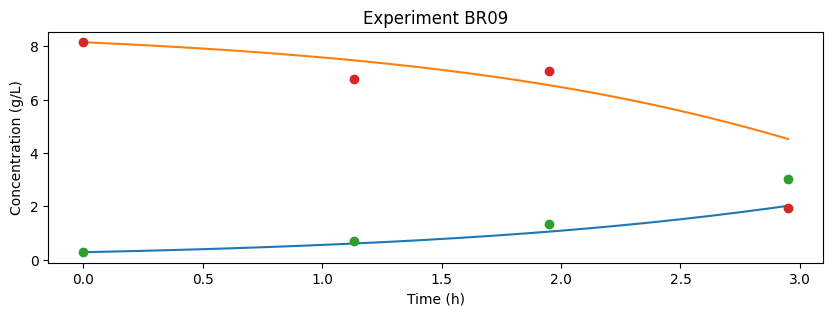

In [22]:
for exp_id in ["BR01", "BR02", "BR03", "BR04", "BR05", "BR06", "BR07", "BR08", "BR09"]:
    df = get_data(exp_id=exp_id, batch=True)
    
    t_start = df['Time'].values[0]
    t_end = df['Time'].values[-1]   
    y_0 = [df['Biomass'].values[0], df['Glucose'].values[0]]
    
    # Solve ODE
    t_span = [t_start, t_end]
    t_eval = df['Time'].values
    sol = solve_ode(mu_max, Km, Y_XS, t_start, t_end, y_0, 1000)

    # Plot solution
    plt.figure(figsize=(10, 3))
    plt.plot(sol.t, sol.y[0], label='Biomass (ODE)')
    plt.plot(sol.t, sol.y[1], label='Glucose (ODE)')
    plt.plot(df['Time'], df['Biomass'], 'o', label='Biomass (Data)')
    plt.plot(df['Time'], df['Glucose'], 'o', label='Glucose (Data)')
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/L)')
    plt.title(f'Experiment {exp_id}')


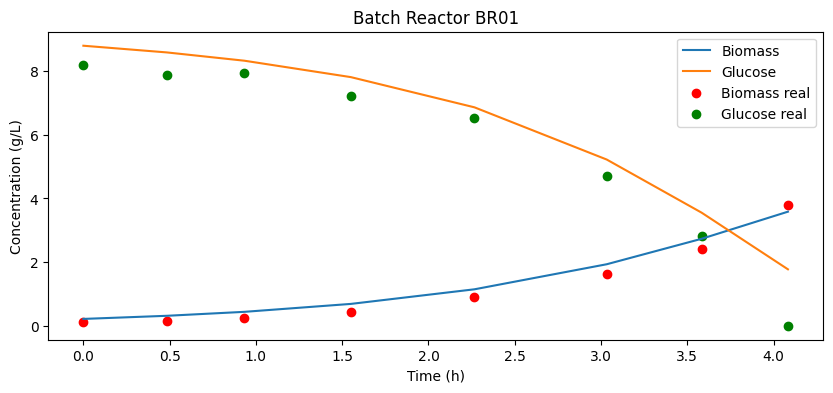

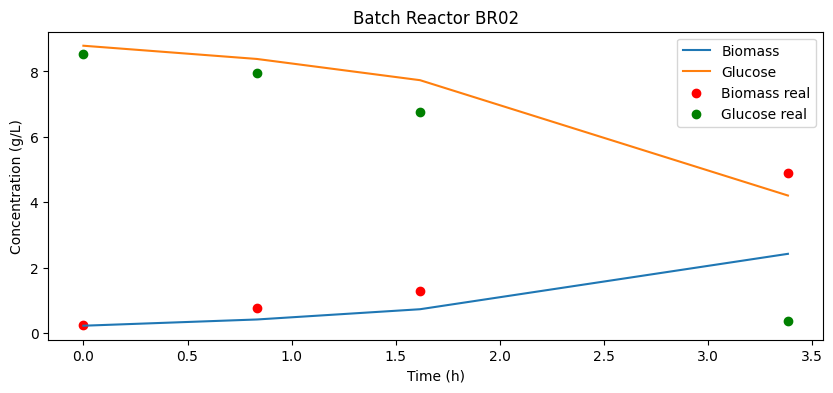

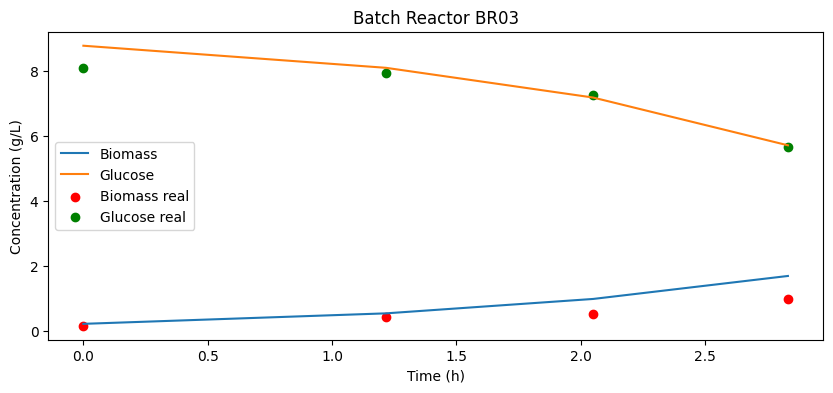

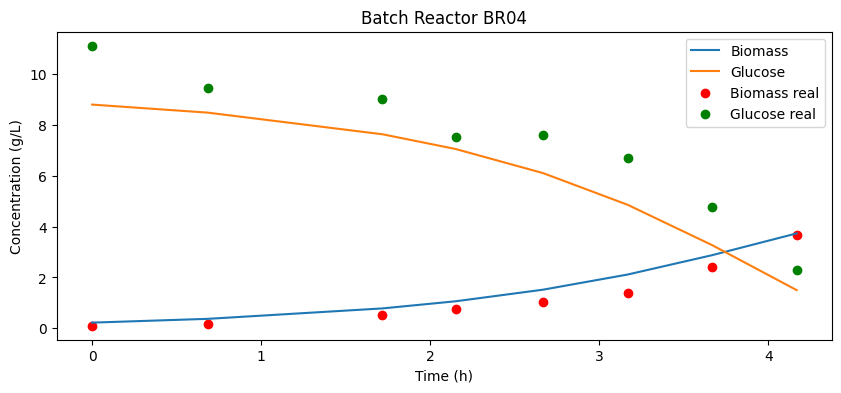

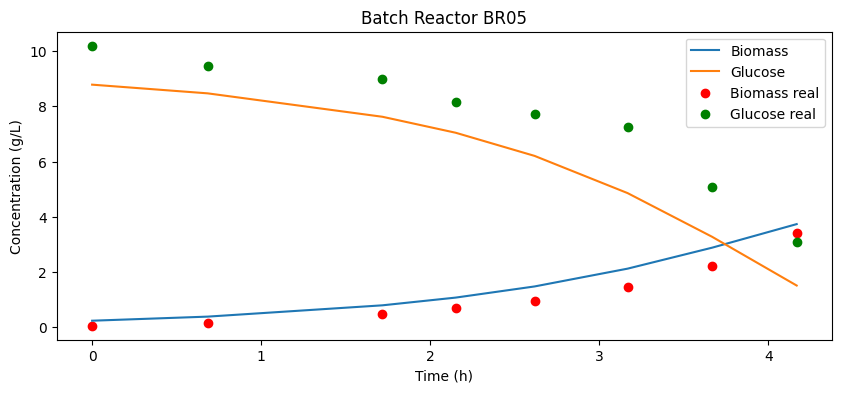

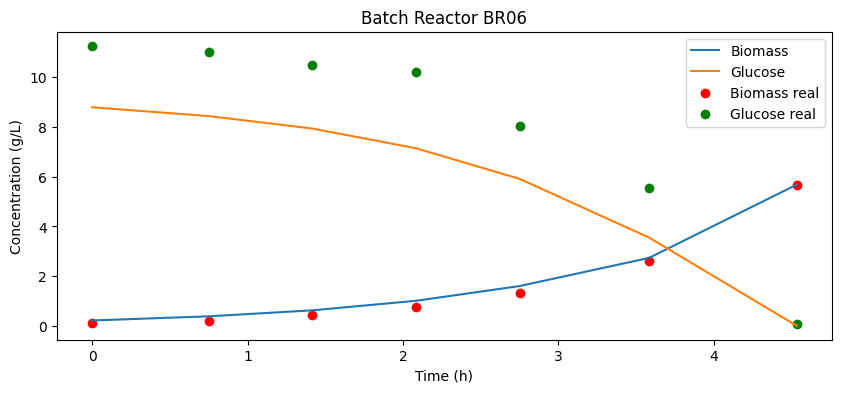

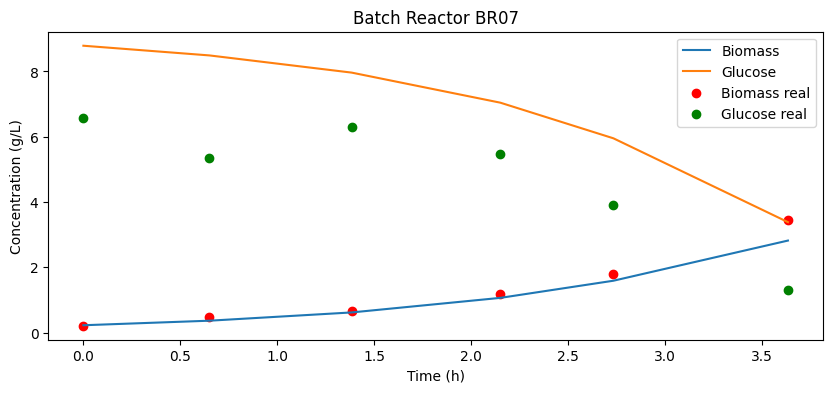

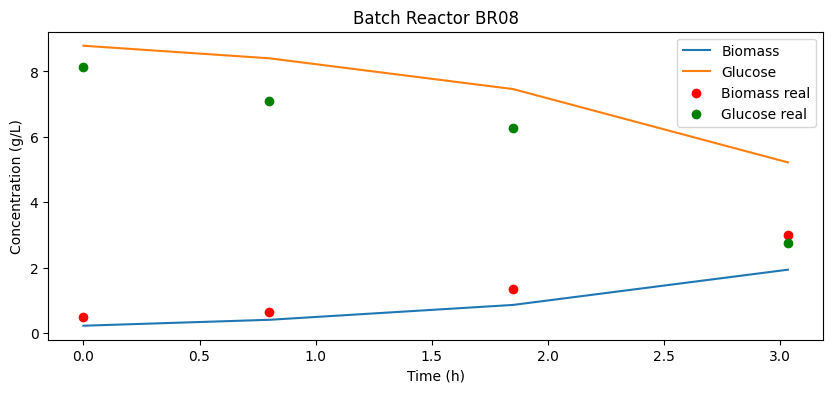

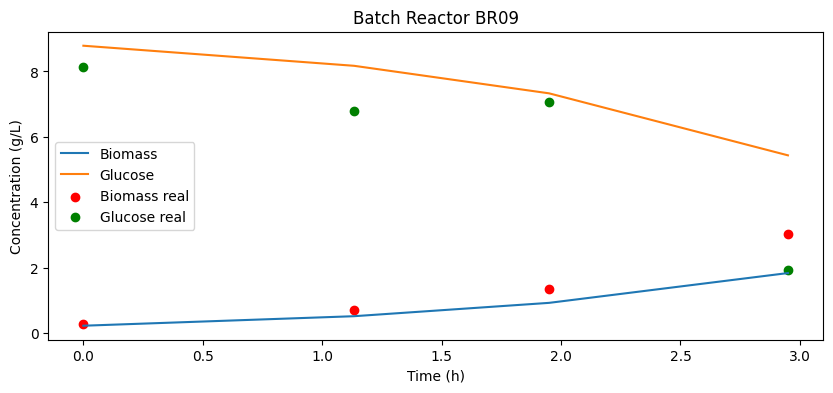

In [23]:
for exp_id in ["BR01", "BR02", "BR03", "BR04", "BR05", "BR06", "BR07", "BR08", "BR09"]:
    df = get_data(exp_id=exp_id, batch=True)
    
    t_start = df['Time'].values[0]
    t_end = df['Time'].values[-1]   
    y_0 = [df['Biomass'].values[0], df['Glucose'].values[0]]

    # Load model
    model = PINN(1, 2, t_start=t_start, t_end=t_end)
    model.load_state_dict(torch.load('./models/pinn_sparse.pth'))
    model.eval()

    t = torch.tensor(np.float32(df['Time'].values)).view(-1, 1)
    y_pred = model(t).detach().numpy()

    # Plot results
    plt.figure(figsize=(10, 4))
    plt.plot(t, y_pred[:, 0], label='Biomass')
    plt.plot(t, y_pred[:, 1], label='Glucose')
    plt.scatter(df['Time'], df['Biomass'], label='Biomass real', color='red')
    plt.scatter(df['Time'], df['Glucose'], label='Glucose real', color='green')
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/L)')
    plt.title(f'Batch Reactor {exp_id}')
    plt.legend()
    plt.show()